## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 31s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [12]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/500

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 142us/step - loss: 198.6154 - accuracy: 0.2584 - val_loss: 41.1742 - val_accuracy: 0.2481
Epoch 2/10
50000/50000 [==============================] - 7s 138us/step - loss: 19.1360 - accuracy: 0.1194 - val_loss: 7.2823 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 7s 139us/step - loss: 4.0984 - accuracy: 0.0982 - val_loss: 2.6458 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 7s 135us/step - loss: 2.4864 - accuracy: 0.0980 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 7s 137us/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 7s 135us/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [==============================] - 

50000/50000 [==============================] - 10s 200us/step - loss: 5.6928 - accuracy: 0.3962 - val_loss: 5.6255 - val_accuracy: 0.4072
Epoch 4/10
50000/50000 [==============================] - 9s 186us/step - loss: 5.5689 - accuracy: 0.4168 - val_loss: 5.5194 - val_accuracy: 0.4227
Epoch 5/10
50000/50000 [==============================] - 9s 181us/step - loss: 5.4573 - accuracy: 0.4318 - val_loss: 5.4095 - val_accuracy: 0.4315
Epoch 6/10
50000/50000 [==============================] - 9s 179us/step - loss: 5.3518 - accuracy: 0.4427 - val_loss: 5.3051 - val_accuracy: 0.4408
Epoch 7/10
50000/50000 [==============================] - 9s 183us/step - loss: 5.2523 - accuracy: 0.4557 - val_loss: 5.2206 - val_accuracy: 0.4498
Epoch 8/10
50000/50000 [==============================] - 10s 200us/step - loss: 5.1575 - accuracy: 0.4656 - val_loss: 5.1236 - val_accuracy: 0.4616
Epoch 9/10
50000/50000 [==============================] - 10s 207us/step - loss: 5.0678 - accuracy: 0.4747 - val_loss: 5.

Epoch 6/10
50000/50000 [==============================] - 6s 123us/step - loss: 5.2439 - accuracy: 0.4456 - val_loss: 5.2037 - val_accuracy: 0.4430
Epoch 7/10
50000/50000 [==============================] - 6s 122us/step - loss: 5.1475 - accuracy: 0.4587 - val_loss: 5.1212 - val_accuracy: 0.4527
Epoch 8/10
50000/50000 [==============================] - 7s 138us/step - loss: 5.0572 - accuracy: 0.4657 - val_loss: 5.0503 - val_accuracy: 0.4507
Epoch 9/10
50000/50000 [==============================] - 6s 119us/step - loss: 4.9706 - accuracy: 0.4762 - val_loss: 4.9631 - val_accuracy: 0.4613
Epoch 10/10
50000/50000 [==============================] - 6s 129us/step - loss: 4.8863 - accuracy: 0.4849 - val_loss: 4.8796 - val_accuracy: 0.4644
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         

Epoch 9/10
50000/50000 [==============================] - 7s 146us/step - loss: 1.4752 - accuracy: 0.4825 - val_loss: 1.4929 - val_accuracy: 0.4750
Epoch 10/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.4473 - accuracy: 0.4917 - val_loss: 1.4747 - val_accuracy: 0.4771
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_______________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 180us/step - loss: 2.1669 - accuracy: 0.2810 - val_loss: 2.0051 - val_accuracy: 0.3424
Epoch 2/10
50000/50000 [==============================] - 9s 170us/step - loss: 1.9478 - accuracy: 0.3679 - val_loss: 1.9075 - val_accuracy: 0.3787
Epoch 3/10
50000/50000 [==============================] - 9s 186us/step - loss: 1.8695 - accuracy: 0.3941 - val_loss: 1.8470 - val_accuracy: 0.4023
Epoch 4/10
50000/50000 [==============================] - 9s 184us/step - loss: 1.8164 - accuracy: 0.4127 - val_loss: 1.7920 - val_accuracy: 0.4188
Epoch 5/10
50000/50000 [==============================] - 9s 189us/step - loss: 1.7694 - accuracy: 0.4280 - val_loss: 1.7553 - val_accuracy: 0.4316
Epoch 6/10
50000/50000 [==============================] - 9s 180us/step - loss: 1.7326 - accuracy: 0.4415 - val_loss: 1.7228 - val_accuracy: 0.4437
Epoch 7/10
50000/50000 [==============================] - 9s 1

50000/50000 [==============================] - 8s 163us/step - loss: 1.7207 - accuracy: 0.3991 - val_loss: 1.6878 - val_accuracy: 0.4098
Epoch 4/10
50000/50000 [==============================] - 8s 162us/step - loss: 1.6603 - accuracy: 0.4194 - val_loss: 1.6403 - val_accuracy: 0.4234
Epoch 5/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.6125 - accuracy: 0.4346 - val_loss: 1.6013 - val_accuracy: 0.4340
Epoch 6/10
50000/50000 [==============================] - 8s 162us/step - loss: 1.5741 - accuracy: 0.4491 - val_loss: 1.5860 - val_accuracy: 0.4362
Epoch 7/10
50000/50000 [==============================] - 8s 164us/step - loss: 1.5394 - accuracy: 0.4610 - val_loss: 1.5424 - val_accuracy: 0.4522
Epoch 8/10
50000/50000 [==============================] - 8s 165us/step - loss: 1.5118 - accuracy: 0.4690 - val_loss: 1.5441 - val_accuracy: 0.4480
Epoch 9/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.4851 - accuracy: 0.4790 - val_loss: 1.500

Epoch 6/10
50000/50000 [==============================] - 8s 159us/step - loss: 1.5681 - accuracy: 0.4509 - val_loss: 1.5568 - val_accuracy: 0.4518
Epoch 7/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.5346 - accuracy: 0.4618 - val_loss: 1.5342 - val_accuracy: 0.4581
Epoch 8/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.5044 - accuracy: 0.4728 - val_loss: 1.5131 - val_accuracy: 0.4643
Epoch 9/10
50000/50000 [==============================] - 8s 159us/step - loss: 1.4761 - accuracy: 0.4819 - val_loss: 1.5360 - val_accuracy: 0.4608
Epoch 10/10
50000/50000 [==============================] - 8s 157us/step - loss: 1.4522 - accuracy: 0.4919 - val_loss: 1.4858 - val_accuracy: 0.4774
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         

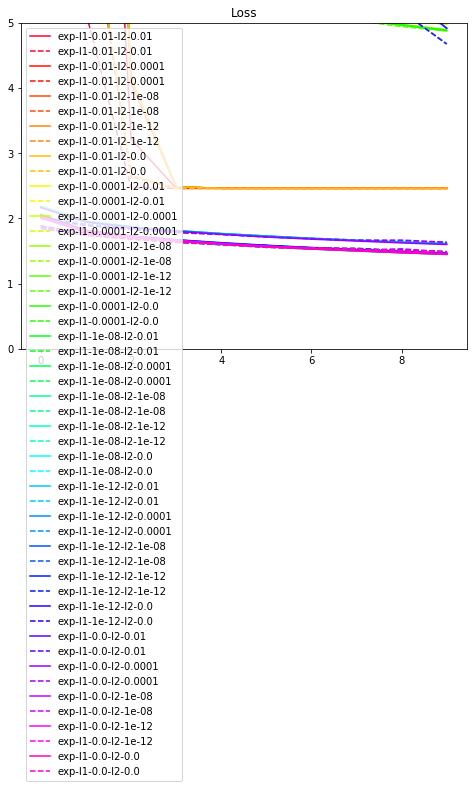

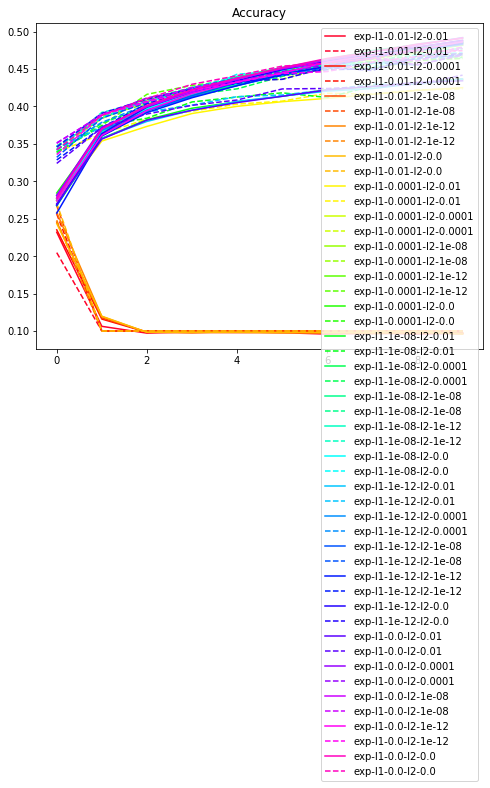

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()